In [1]:
video_index = 4
frame_index = 100

## get the flow matrix for desired frames

In [2]:
# Load frames 184 and 185 from the video
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the yolo/src directory to the Python path
sys.path.append('src')

# Import the necessary functions
from flow import calculate_flow
from segmentation import VehicleDetector


focal_length = 910
# Use the correct path to the video
video_path = f'../labeled/{video_index}.hevc'

# Open the video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video at {video_path}")
else:
    # Get total frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    
    # Set frame numbers
    frame1_num = frame_index - 1
    frame2_num = frame_index
    print(f"prev frame number: {frame1_num}")
    dil_size = 10
    
    # Get frame 1 - Make sure to reset position and read frames sequentially
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i in range(frame1_num):  # +1 because we're 0-indexed
        ret1, frame1 = cap.read()
        if not ret1:
            print(f"Error: Could not read frame {i}")
            break
    
    # Get frame 2 - Continue reading from current position
    ret2, frame2 = cap.read()
    
    if ret1 and ret2:
        # Verify we're at the right frames
        print(f"Current frame position: {int(cap.get(cv2.CAP_PROP_POS_FRAMES))}")
        
        # Initialize vehicle detector
        detector = VehicleDetector()
        
        # Detect vehicles and create masks
        vehicle_mask1 = detector.detect_vehicles(frame1)
        vehicle_mask2 = detector.detect_vehicles(frame2)
        vehicle_mask1 = detector.dilate_mask(vehicle_mask1, dil_size)
        vehicle_mask2 = detector.dilate_mask(vehicle_mask2, dil_size)
        
        # Charger le masque manuel sauvegardé
        mask_path = '../masks/4_mask.png'
        if os.path.exists(mask_path):
            manual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # S'assurer que le masque a la même taille que les frames
            if manual_mask.shape != vehicle_mask1.shape:
                manual_mask = cv2.resize(manual_mask, (vehicle_mask1.shape[1], vehicle_mask1.shape[0]))
        else:
            print(f"Attention: masque manuel non trouvé à {mask_path}, un masque vide sera utilisé.")
            manual_mask = np.zeros_like(vehicle_mask1)

        # Combine masks
        combined_mask = detector.combine_masks(manual_mask, vehicle_mask2, vehicle_mask1)

        
        # Convert to grayscale
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow
        flow, prev_gray_masked, gray_masked = calculate_flow(gray1, gray2, combined_mask)

Total frames in video: -192153584101141
prev frame number: 99
Current frame position: 100


In [8]:
flow.size * flow.itemsize/1e9 * 100

0.8138688

In [14]:
flow[flow>1e-2].size * flow.itemsize/1e9 * 600 *2

0.8778336

In [15]:
flow.dtype

dtype('float32')

## Display the second frame with flow vectors

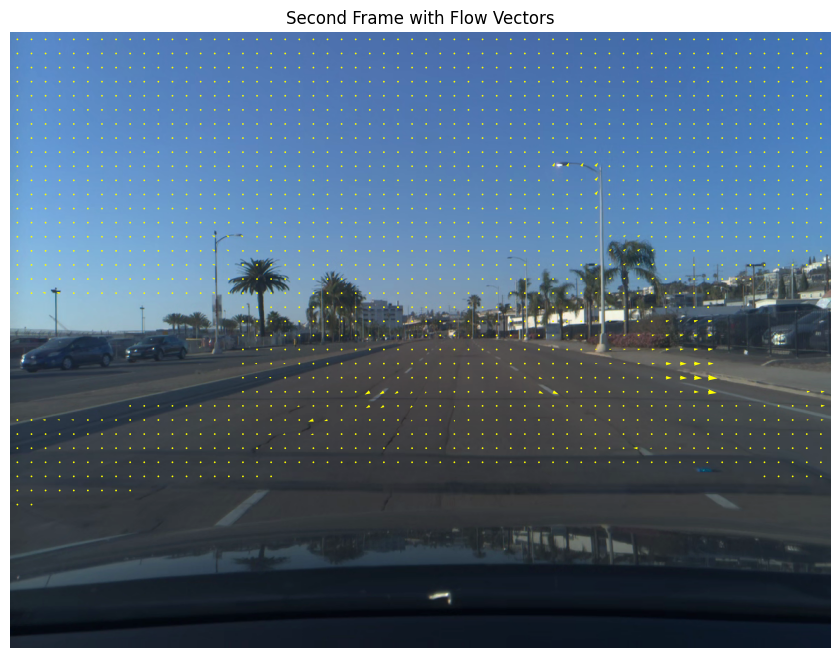

In [17]:
# Display the second frame with flow vectors
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Second Frame with Flow Vectors')

# Plot flow vectors
# Subsample the flow field for better visualization
step = 20  # Adjust this value to change the density of arrows
h, w = flow.shape[:2]
y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
fx, fy = flow[y, x].T

# Create a mask for valid flow vectors (non-zero)
valid = (fx != 0) | (fy != 0)

plt.quiver(x[valid], y[valid], fx[valid], fy[valid], 
           color='yellow', angles='xy', scale_units='xy', scale=1)

plt.axis('off')
plt.show()

## Get the ground truth and initialize the estimator

In [3]:
from colinearity_optimization import VanishingPointEstimator
from ground_truth import get_frame_pixels

label_point = get_frame_pixels(video_index, frame_index)

ve = VanishingPointEstimator(
    frame_width=frame2.shape[1], 
    frame_height=frame2.shape[0], 
    use_max_distance=False,
    use_reoptimization=False
)

In [5]:
from flow_filter import FlowFilter
def error_norm_threshold(flow, label_point, threshold:float, weight_mode='linear', weight_power=1.0):
    #print(f"Testing threshold: {threshold}")  # Debug print
    filt = FlowFilter(
        min_norm_threshold=threshold, 
        weight_mode=weight_mode, 
        weight_power=weight_power
    )
    filtered_flow, weights = filt.filter_by_norm(flow)
    ve.initial_vanishing_point = (1,1)
    predicted_vanishing_point = ve.find_vanishing_point_lbfgsb(
        flow=filtered_flow, 
        weights=weights, 
        visualize=False 
    )
    distance = np.linalg.norm(np.array(predicted_vanishing_point) - np.array(label_point))
    #print(f"Error: {distance}")  # Debug print
    return distance

## Recherche exhaustive simple

In [6]:
from tqdm import tqdm
from itertools import product
weight_powers = [0.5, 1.0, 1.5, 2.0]
thresh = 1e-2
param_space = {
    'weight_modes': ['linear', 'inverse', 'power', 'exp', 'log', 'constant'],
    'thresholds': [1e-2, 1e-1, 1e0, 1e1, 1e2],
    'weight_powers': [2.0]
}

# Générer toutes les combinaisons
keys = param_space.keys()
values = param_space.values()

all_results = []

# Barre de progression pour suivre l'avancement
total_configs = np.prod([len(v) for v in values])
print(f"Évaluation de {total_configs} configurations...")

# Parcourir toutes les combinaisons
for combination in tqdm(product(*values), total=total_configs):
    config = dict(zip(keys, combination))
    error = error_norm_threshold(flow, label_point, config['thresholds'], config['weight_modes'], config['weight_powers'])
    all_results.append({
        'config': config,
        'error': error
    })


# Trier les résultats par erreur moyenne
sorted_results = sorted(all_results, key=lambda x: x['error'])
sorted_results[0]

Évaluation de 30 configurations...


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


{'config': {'weight_modes': 'linear',
  'thresholds': 100.0,
  'weight_powers': 2.0},
 'error': np.float64(51.19570294468082)}

In [18]:
sorted_results = sorted(all_results, key=lambda x: x['error'])
sorted_results

[{'config': {'weight_modes': 'linear',
   'thresholds': 100.0,
   'weight_powers': 2.0},
  'error': np.float64(51.19570294468082)},
 {'config': {'weight_modes': 'inverse',
   'thresholds': 100.0,
   'weight_powers': 2.0},
  'error': np.float64(51.19570294468082)},
 {'config': {'weight_modes': 'power',
   'thresholds': 100.0,
   'weight_powers': 2.0},
  'error': np.float64(51.19570294468082)},
 {'config': {'weight_modes': 'exp', 'thresholds': 100.0, 'weight_powers': 2.0},
  'error': np.float64(51.19570294468082)},
 {'config': {'weight_modes': 'log', 'thresholds': 100.0, 'weight_powers': 2.0},
  'error': np.float64(51.19570294468082)},
 {'config': {'weight_modes': 'power', 'thresholds': 1.0, 'weight_powers': 2.0},
  'error': np.float64(55.38663363722529)},
 {'config': {'weight_modes': 'power', 'thresholds': 0.1, 'weight_powers': 2.0},
  'error': np.float64(55.637141389517154)},
 {'config': {'weight_modes': 'power',
   'thresholds': 0.01,
   'weight_powers': 2.0},
  'error': np.float64(55

In [8]:
from scipy.optimize import minimize
thresh_opt = minimize(
    lambda thresh: error_norm_threshold(flow, label_point, float(thresh[0]) if isinstance(thresh, np.ndarray) else float(thresh)),
    np.array([1e1]),  # Initial value as a numpy array
    method='L-BFGS-B',
    bounds=[(1e-8, 1e4)],
    options={
        'disp': True,
        # 'maxiter': 100,  # Increase maximum iterations
        # 'ftol': 1e-4,    # Relax the function tolerance
        # 'gtol': 1e-4,    # Relax the gradient tolerance
        # 'eps': 1e-2      # Increase the step size for numerical gradient
    }
)
        


Testing threshold: 10.0
Error: 62.89092149573108
Testing threshold: 10.00000001
Error: 62.89092149573108


Testing threshold: 1.0
Error: 97.78588178579726
Threshold: 1.0, Error: 97.78588178579726
Testing threshold: 1.6681005372000588
Error: 60.47411822682557
Threshold: 1.6681005372000588, Error: 60.47411822682557
Testing threshold: 2.7825594022071245
Error: 50.93412017663605
Threshold: 2.7825594022071245, Error: 50.93412017663605
Testing threshold: 4.641588833612778
Error: 37.735601597410245
Threshold: 4.641588833612778, Error: 37.735601597410245
Testing threshold: 7.742636826811269
Error: 32.05237086238573
Threshold: 7.742636826811269, Error: 32.05237086238573
Testing threshold: 12.91549665014884
Error: 733.7971768948947
Threshold: 12.91549665014884, Error: 733.7971768948947
Testing threshold: 21.544346900318832
No valid pixels found
returning initial vanishing point: (1, 1)
Error: 760.7798630352935
Threshold: 21.544346900318832, Error: 760.7798630352935
Testing threshold: 35.93813663804626
No valid pixels found
returning initial vanishing point: (1, 1)
Error: 760.7798630352935
Threshold: 

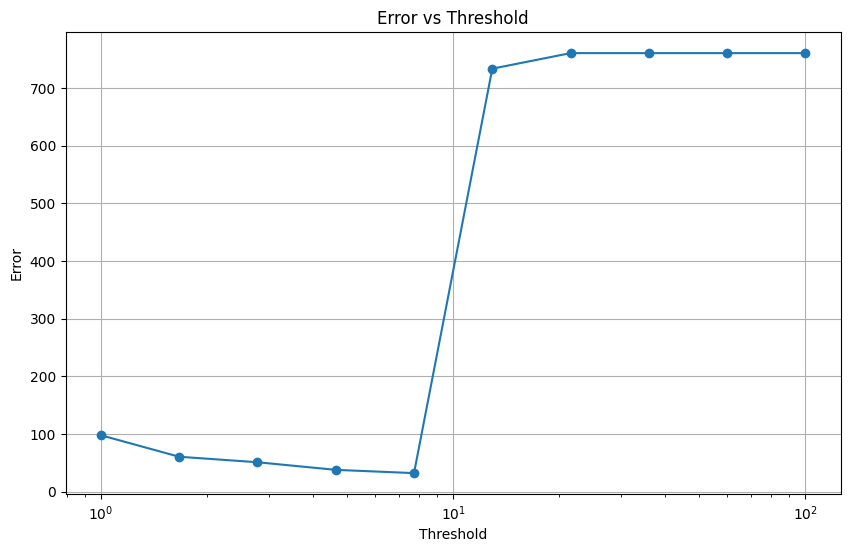

In [22]:
# Grid search to understand the function behavior
thresholds = np.logspace(0, 2, 10)  # 50 points between 1e-4 and 1e2
errors = []
for thresh in thresholds:
    error = error_norm_threshold(flow, label_point, thresh)
    errors.append(error)
    print(f"Threshold: {thresh}, Error: {error}")

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.semilogx(thresholds, errors, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.title('Error vs Threshold')
plt.grid(True)
plt.show()

In [32]:
tot_vid_size = flow.size * flow.itemsize * 1200 / 1e9 
print(f"Total size of flow matrices for 1 video of 1200 frames: {tot_vid_size} GB")

Total size of flow matrices for 1 video of 1200 frames: 9.7664256 GB


In [30]:
flow.itemsize

4

In [33]:
flow = np.zeros((2, 480, 640))
print(f'flow.size: {flow.size}')
print(f'flow.itemsize: {flow.itemsize}')
print(f'Total size in GB: {flow.size * flow.itemsize * 1200 / 1e9}')

flow.size: 614400
flow.itemsize: 8
Total size in GB: 5.89824


In [29]:
flow.size * 1.5 * 1200 / (37.5 * 1e6)

97.664256

In [41]:
# Try multiple initial values
initial_values = [5, 10, 15, 20]
best_result = None
best_error = float('inf')

for init_val in initial_values:
    result = minimize(
        lambda thresh: error_norm_threshold(flow, label_point, thresh),
        init_val,
        method='L-BFGS-B',
        bounds=[(0, None)],
        options={'disp': True}
    )
    print(result.fun)
    if result.fun < best_error:
        best_error = result.fun
        best_result = result

Testing threshold: [          5]
Error: 631.1895405810158
Testing threshold: [          5]
Error: 631.1895405810158
631.1895405810158
Testing threshold: [         10]
Error: 652.2467411566175
Testing threshold: [         10]
Error: 652.2467411566175
652.2467411566175
Testing threshold: [         15]
Error: 349.41234285625853
Testing threshold: [         15]
Error: 349.41234285625853
349.41234285625853
Testing threshold: [         20]
Error: 266.52392636515486
Testing threshold: [         20]
Error: 266.52392636515486
266.52392636515486


In [15]:
filtered_flow = filter_norm_min_thresh(flow, 100)
ve.frame_width = 1
ve.frame_height = 1
predicted_vanishing_point = ve.find_vanishing_point_lbfgsb(
    filtered_flow, 
    visualize=False,
    ground_truth_point=label_point
)
print(predicted_vanishing_point)

(np.float64(582.0), np.float64(437.0))


In [39]:
error_norm_threshold(flow, label_point, 1e1)

Testing threshold: 10.0
Error: 652.2467411566175


np.float64(652.2467411566175)

In [10]:
%%timeit
error_norm_threshold(flow, label_point, 1e1)

116 ms ± 538 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
import numpy as np
flows = np.load('../flows/0.npy')
print(f"Shape of flows: {flows.shape}")
print(f"Data type: {flows.dtype}")
print(f"Min value: {np.min(flows)}")
print(f"Max value: {np.max(flows)}")
print(f"Mean value: {np.mean(flows)}")



Shape of flows: (1199, 874, 1164, 2)
Data type: float32
Min value: -70.79875946044922
Max value: 70.43953704833984
Mean value: 0.10094693303108215


In [3]:
from ground_truth import read_ground_truth_pixels

gt_pixels = read_ground_truth_pixels(0)
gt_pixels = gt_pixels[1:]
print(f"Shape of gt_pixels: {np.array(gt_pixels).shape}")
print(f"Data type: {np.array(gt_pixels).dtype}")
print(f"Min value: {np.min(np.array(gt_pixels))}")
print(f"Max value: {np.max(np.array(gt_pixels))}")

Shape of gt_pixels: (1199, 2)
Data type: int64
Min value: 404
Max value: 613


In [22]:
ve.objective_function(gt_pixels[0], flows[0])

np.float64(-0.38076146302539404)

100%|██████████| 1199/1199 [00:27<00:00, 43.60it/s]


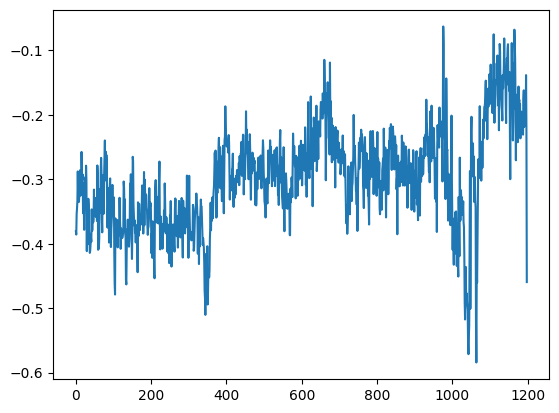

In [26]:
from tqdm import tqdm
scores = []
for i in tqdm(range(len(flows)), total=len(flows)):
    scores.append(ve.objective_function(gt_pixels[i], flows[i]))
plt.plot(scores)
plt.show()


In [4]:
from colinearity_optimization_parallel import ParallelVanishingPointEstimator
pve = ParallelVanishingPointEstimator(frame_width=flows.shape[2], frame_height=flows.shape[1], use_max_distance=False, use_reoptimization=False)


In [5]:
import mlx.core as mx
xflow = mx.array(flows[0])

In [25]:
%%timeit
pve.compute_colinearity_map(xflow, gt_pixels[0])

3.14 ms ± 334 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%timeit
ve.compute_colinearity_map(flows[0], gt_pixels[0])

1.85 s ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
para_map = pve.compute_colinearity_map(xflow, gt_pixels[0])
seq_map = ve.compute_colinearity_map(flows[0], gt_pixels[0])
np.allclose(para_map, seq_map)
para_map.shape
seq_map.shape
para_map.dtype
seq_map.dtype


dtype('float64')

In [27]:
np.allclose(para_map, seq_map)

True

In [11]:
pve.colin_score(xflow, gt_pixels[0])

0.3910050094127655

In [9]:
xflows = mx.array(flows)
xgt_pixels = mx.array(gt_pixels)

100%|██████████| 1199/1199 [00:10<00:00, 114.26it/s]


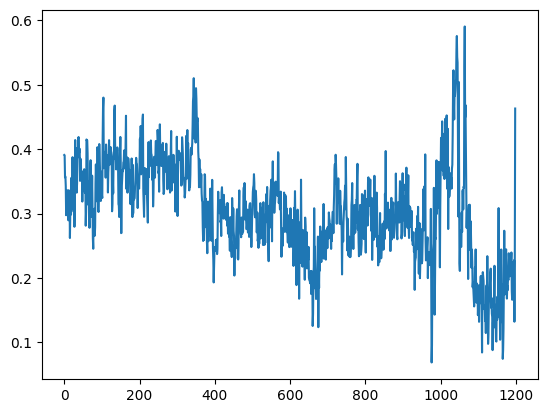

In [13]:
from tqdm import tqdm
scores = []
for i in tqdm(range(len(flows)), total=len(flows)):
    scores.append(pve.colin_score(xflows[i], gt_pixels[i]))
plt.plot(scores)
plt.show()

In [14]:
type(xflows)

mlx.core.array

In [15]:
type(gt_pixels)

list

In [1]:
pve.colin_score_batch(xflows, xgt_pixels)

NameError: name 'pve' is not defined

## Test d'une évaluation en parallèle

In [1]:
import numpy as np
import mlx.core as mx

from flow_filter import FlowFilter
from colinearity_optimization_parallel import ParallelVanishingPointEstimator
from ground_truth import read_ground_truth_pixels

# Load data
flows = np.load('../flows/0.npy')
# Convert to MLX array once
xflows = mx.array(flows)
gt_pixels = np.array(read_ground_truth_pixels(0)[1:])
xgt_pixels = mx.array(gt_pixels)

In [3]:
flow_filter = FlowFilter(min_norm_threshold=1e-2, weight_mode='linear')
filtered_flows, weights = flow_filter.filter_by_norm_batch(xflows)

In [4]:



pve = ParallelVanishingPointEstimator(
        frame_width=flows.shape[2], 
        frame_height=flows.shape[1], 
        use_max_distance=False, 
        use_reoptimization=False
    )
scores = pve.colin_score_batch(filtered_flows, xgt_pixels, weights=weights, chunk_size=10)



: 

In [ ]:
mx.mean(scores)